# I have a list of genes. Which ones show up in Open Targets?

> Sanyal (who works on Parkinson’s) sent me a list of genes that were found in a fly screen for Parkinson disease. He was wondering which ones also had evidence in Open Targets for Parkinson's.

When an experiment or a genetic screen returns a large number of genes involved in a disease, a scientist often needs a way to reduce the number of targets to follow up. One way to prioritize which targets to pursue further is to find out what evidence already connects some of the targets to a given disease.

We can use the Target Validation Platform API to find out i) whether a target has been associated with the disease we are interested in and ii) what evidence lies behind that connection.

First all we import the necessary packages:

In [20]:
import requests
import sys
import csv
import logging
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from io import StringIO
%matplotlib inline

In [3]:
sns.set_context("talk")
sns.set_style("whitegrid")

It is useful to fix the version of the API we will be using. Different versions can have different methods and usually refer to different data releases.

In [4]:
TARGVAL_BASEURL = 'https://www.targetvalidation.org/api/1.1/'

As explained in our [blog about keys authentication](https://blog.opentargets.org/once-you-have-an-api-key/) if you have an API key, you can create a function to deal with the authentication for you. This is by no means a necessary step, unless you have lots and lots of genes to query.

In [5]:
def get_token(app_name,secret):
    jwt = requests.get(TARGVAL_BASEURL + 'public/auth/request_token',
                     params={'app_name':app_name,'secret':secret})
    return jwt.json()['token']

It is much nicer to use gene symbols, rather than the cumbersome `ENSG` ids from Ensembl. We can define two alternative methods to retrieve a symbol name. One leveraging the ENSEMBL API directly, the other using our API. 

In [6]:
def symbol2ensemble(symbol):
    '''
    returns ensembl gene id for a gene symbol,
    leveraging the ensembl rest api
    '''
    headers = {'content-type':'application/json'}
    human_url = 'http://rest.ensembl.org/xrefs/symbol/homo_sapiens/'
    r = requests.get(human_url + symbol, headers=headers)
    return r.json()[0]['id']

assert symbol2ensemble('SOD1') == 'ENSG00000142168'

In [7]:
def get_ensid(genesymbol):
    '''
    uses the targetvalidation.org API to get ENS IDs
    '''
    r = requests.get(TARGVAL_BASEURL + 'public/search', 
                     params={'q':genesymbol,'size':1,'filter':'gene'})
    result = r.json()
    if result["data"][0]["data"]["approved_symbol"] == genesymbol:
         geneId = result["data"][0]["id"]
    return geneId

assert get_ensid('SOD1') == 'ENSG00000142168'

## Generate a random set of genes symbols
You normally will have a list of genes coming from an experiment or a genetic screen. For this example, we will pick a random list. To do that, we can use the complete set of HGNC gene names. We first parse it in the command line, to get a smaller, cleaned-up version.

In [10]:
%%capture
%%bash
# Generate a random set of genes symbols
if [ ! -f hgnc_symbol_set.txt ]; then
    wget http://ftp.ebi.ac.uk/pub/databases/genenames/hgnc_complete_set.txt.gz && gunzip hgnc_complete_set.txt.gz 
    tail -n +2 hgnc_complete_set.txt | cut -f2 | grep -v withdrawn > hgnc_symbol_set.txt  
fi

Then read it into python and take a random subsample:

In [14]:
hgnc_symbols = pd.read_table('hgnc_symbol_set.txt',header=None,names=['gene'])
random_genes = list(hgnc_symbols.sample(n=50).gene)
print(random_genes)

['ALOX12-AS1', 'FRA22A', 'HCG17', 'AK6P1', 'COL27A1', 'EEF1A1P2', 'CCNL2', 'CCDC25', 'EIF1AXP1', 'HBAP1', 'DFNA16', 'CGB7', 'DEPDC7', 'DEFB119', 'GLC2A', 'C22orf29', 'CXCL11', 'AQP4', 'ADAM7', 'CCDC88C', 'GALM', 'DUSP8P5', 'HNRNPA1P30', 'BIN1', 'ATP6V1C2', 'ANGPTL3', 'FCF1P1', 'ECD', 'HEXDC-IT1', 'CCDC50', 'CARD16', 'IFT52', 'DOCK10', 'FRAXF', 'ABLIM2', 'DYNC1LI2', 'GLUD1P6', 'ADIPOQ-AS1', 'GABRA4', 'H2BFS', 'AMY1C', 'CTBP2P8', 'FBXO27', 'F2', 'FRG2EP', 'ATP5J2-PTCD1', 'HIST1H4B', 'GLULP6', 'DFNA37', 'FAM86B2']


## Find out the EFO code for your disease of interest

The API uses `EFO` id to query for diseases in an unequivocal fashion. To find out the EFO ID for your disease of interest, you can use the `search` method in the API.

In [15]:
def get_efoid(diseasestr):
    '''
    uses the targetvalidation.org API to get EFO IDs
    '''
    r = requests.get(TARGVAL_BASEURL + 'public/search', 
                     params={'q':diseasestr,'size':1,'filter':'disease'})
    result = r.json()
    diseaseId = result["data"][0]["data"]["efo_code"]
    return diseaseId

assert get_efoid('asthma') == 'EFO_0000270'

In [16]:
PARKINSON = get_efoid('parkinson')
NEURO = get_efoid('nervous system disease')

## Retrieve the association score tables for a given disease
We can use the CSV structure that the REST API already forms for us

In [17]:
parkinson_csv = {'disease':PARKINSON,
          'outputstructure':'flat',
          'facets':'false',
          'format':'csv',
          'size':'10000',
          'fields':['target.gene_info.symbol',
                    'association_score.overall',
                    'association_score.datatypes.genetic_association',
                    'association_score.datatypes.somatic_mutation',
                    'association_score.datatypes.known_drug',
                    'association_score.datatypes.affected_pathway',
                    'association_score.datatypes.rna_expression',
                    'association_score.datatypes.literature',
                    'association_score.datatypes.animal_model',
                    'target.gene_info.name'],
          'from':'0',
          'scorevalue_min':'0'
          }
r = requests.get(TARGVAL_BASEURL + 'public/association/filter', params = parkinson_csv)
df = pd.read_csv(StringIO(r.text),header=0,index_col=0)
df.head()

,association_score.overall,association_score.datatypes.genetic_association,association_score.datatypes.somatic_mutation,association_score.datatypes.known_drug,association_score.datatypes.affected_pathway,association_score.datatypes.rna_expression,association_score.datatypes.literature,association_score.datatypes.animal_model,target.gene_info.name
target.gene_info.symbol,,,,,,,,,
DRD2,1.0,0.0,0.0,1.0,0.0,0.0,0.192104,0.413354,dopamine receptor D2
DRD3,1.0,0.0,0.0,1.0,0.0,0.0,0.122070,0.000000,dopamine receptor D3
CHRM1,1.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.000000,cholinergic receptor muscarinic 1
DRD4,1.0,0.0,0.0,1.0,0.0,0.0,0.081254,0.000000,dopamine receptor D4
GRIN2B,1.0,0.0,0.0,1.0,0.0,0.0,0.115558,0.000000,glutamate ionotropic receptor NMDA type subuni...


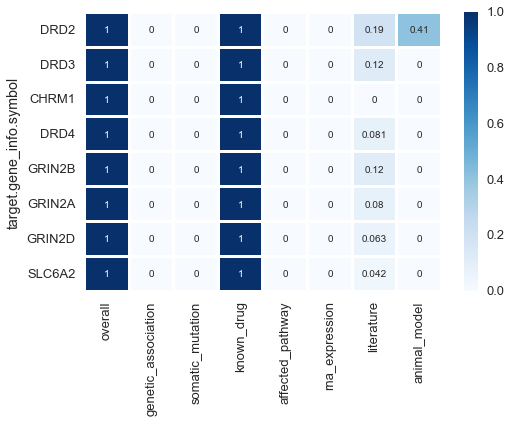

In [39]:
# copying from Theo.. 
f, ax = plt.subplots(figsize=(8,5))
ax = sns.heatmap(df.iloc[:8,0:8], cmap="Blues", annot=True, linewidths=2)
# fix labels
labels = [item.get_text().split('.')[-1] for item in ax.get_xticklabels()]
t = ax.set_xticklabels(labels)

## Filter out only genes that are also in your list
We will use the random list we generated above, and find out which of the genes in the list have associations with Parkinson's according to the Target Validation Platform.

In [30]:
df[df.index.isin(random_genes)]

,association_score.overall,association_score.datatypes.genetic_association,association_score.datatypes.somatic_mutation,association_score.datatypes.known_drug,association_score.datatypes.affected_pathway,association_score.datatypes.rna_expression,association_score.datatypes.literature,association_score.datatypes.animal_model,target.gene_info.name
target.gene_info.symbol,,,,,,,,,
GABRA4,1.000000,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,gamma-aminobutyric acid type A receptor alpha4...
AQP4,0.082001,0.0,0.0,0.0,0.0,0.0,0.082001,0.0,aquaporin 4
ECD,0.079027,0.0,0.0,0.0,0.0,0.0,0.079027,0.0,ecdysoneless cell cycle regulator
BIN1,0.029200,0.0,0.0,0.0,0.0,0.0,0.029200,0.0,bridging integrator 1


Now you can display an associations heatmap, which shows the [association score](https://www.targetvalidation.org/scoring) for each data type supporting the connection between target and disease

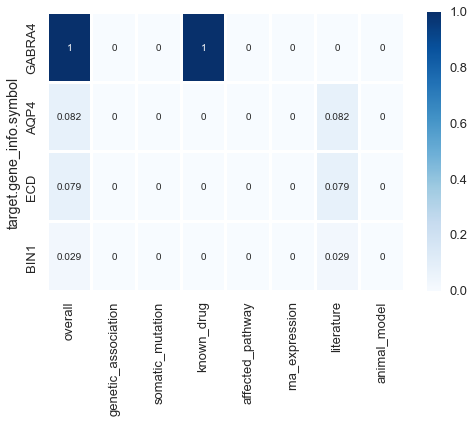

In [41]:
f, ax = plt.subplots(figsize=(8,5))
ax = sns.heatmap(df.iloc[df.index.isin(random_genes),0:8], cmap="Blues", annot=True, linewidths=2)
# fix labels
labels = [item.get_text().split('.')[-1] for item in ax.get_xticklabels()]
t = ax.set_xticklabels(labels)

## Split the genetic evidence in mendelian vs gwas